# Choroid Plexus Segmentation Training via Auto3DSeg

In [3]:
import os
import json
import nibabel as nib
import nibabel as nibabel
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import random
from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/.virtualenvs/monai/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.42.4
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: 1.16.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Prep the database

In [7]:
# No prep necessary - single channel input

## Review

In [2]:
def display_slices(path):
    img1 = nibabel.load(os.path.join(path, "flair.nii.gz"))
    img2 = nibabel.load(os.path.join(path, "flair_chp_mask_qced.nii.gz"))

    data1 = img1.get_fdata()[:,:,:]
    data2 = img2.get_fdata()

    slice_sums = np.sum(data2, axis=(0, 1))
    
    print(slice_sums)

    max_slice_index = np.argmax(slice_sums)
    print(f"Max slice: {max_slice_index}")

    slice1 = data1[:, :, max_slice_index]
    slice2 = data2[:, :, max_slice_index]    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(slice1, cmap='gray')
    plt.title(f"Image 1 - Slice {max_slice_index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(slice2, cmap='gray')
    plt.title(f"Image 2 - Slice {max_slice_index}")
    plt.axis('off')
    plt.show()


[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.  54.  86. 128.
 130. 101. 130. 195.  18.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
Max slice: 31


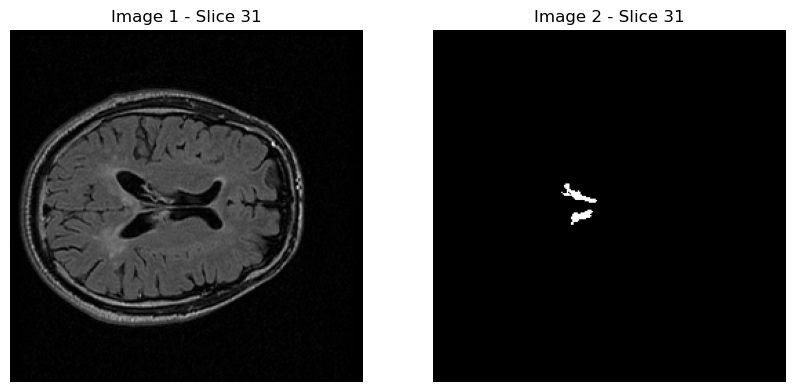

In [3]:
display_slices('/datasets/choroid-plexus/train/V00_EX400072')

In [4]:
dataroot = '/datasets/choroid-plexus/train'

def complete_case(case):
    return os.path.isfile(dataroot + '/' + case['image']) and \
        os.path.isfile(dataroot + '/' + case['label']) and \
        np.sum(nibabel.load(dataroot + '/' + case['label']).get_fdata()[:]) > 0

exam_paths = [path.replace(dataroot + '/','') for path in sorted(glob.glob(dataroot + "/*"))]

random.seed(1)
random.shuffle(exam_paths)

train_num = int(np.floor(len(exam_paths) * 0.85))

train_exams = exam_paths[0:train_num]
test_exams = exam_paths[train_num:]

print(f"Train exam num: {len(train_exams)}")
print(f"Test exam num: {len(test_exams)}")

train_data = [{'image': path + '/flair.nii.gz', 'label': path + '/flair_chp_mask_qced.nii.gz'} for path in train_exams]

test_data = [{'image': path + '/flair.nii.gz', 'label': path + '/flair_chp_mask_qced.nii.gz'} for path in test_exams]

train_data = [e for e in train_data if complete_case(e)]
test_data = [e for e in test_data if complete_case(e)]

print()

print(f"Train num total: {len(train_data)}")
print(f"Test num: {len(test_data)}")

Train exam num: 199
Test exam num: 36

Train num total: 199
Test num: 36


In [5]:
datalist = {
    "testing": test_data,
    "training": [{"fold": i % 5, "image": c["image"], "label": c["label"]} for i,c in enumerate(train_data)]
}

In [6]:
datalist

{'testing': [{'image': 'V00_EX400030/flair.nii.gz',
   'label': 'V00_EX400030/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX403611/flair.nii.gz',
   'label': 'V00_EX403611/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX400455/flair.nii.gz',
   'label': 'V00_EX400455/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX400150/flair.nii.gz',
   'label': 'V00_EX400150/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX400856/flair.nii.gz',
   'label': 'V00_EX400856/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX400322/flair.nii.gz',
   'label': 'V00_EX400322/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX401056/flair.nii.gz',
   'label': 'V00_EX401056/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX400390/flair.nii.gz',
   'label': 'V00_EX400390/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX400643/flair.nii.gz',
   'label': 'V00_EX400643/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX401025/flair.nii.gz',
   'label': 'V00_EX401025/flair_chp_mask_qced.nii.gz'},
  {'image': 'V00_EX

In [7]:
work_dir = "./cp_work_dir_20231215"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = dataroot
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "datalist.json")
with open(datalist_file, "w") as f:
    json.dump(datalist, f)

In [8]:
runner = AutoRunner(
    work_dir=work_dir,
    algos=["swinunetr"],
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
)

2023-12-15 16:55:09,315 - INFO - AutoRunner using work directory ./cp_work_dir_20231215
2023-12-15 16:55:09,317 - INFO - Setting num_fold 5 based on the input datalist /home/ec2-user/choroid_plexus/cp_work_dir_20231215/datalist.json.
2023-12-15 16:55:09,342 - INFO - Using user defined command running prefix , will override other settings


In [11]:
max_epochs = 100

train_param = {
    "num_epochs_per_validation": 1,
    #"num_images_per_batch": 10,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)

In [12]:
runner.run()

2023-12-15 16:56:24,656 - INFO - Running data analysis...
2023-12-15 16:56:24,657 - INFO - Found 4 GPUs for data analyzing!


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


2023-12-15 16:56:54,693 - INFO - Data spacing is not completely uniform. MONAI transforms may provide unexpected result
2023-12-15 16:56:54,694 - INFO - Writing data stats to /home/ec2-user/choroid_plexus/cp_work_dir_20231215/datastats.yaml.
2023-12-15 16:56:54,705 - INFO - Writing by-case data stats to /home/ec2-user/choroid_plexus/cp_work_dir_20231215/datastats_by_case.yaml, this may take a while.
2023-12-15 16:56:55,530 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/249bf4b.tar.gz


algo_templates.tar.gz: 104kB [00:00, 649kB/s]                                                                                                                                                                                                  

2023-12-15 16:56:55,710 - INFO - Downloaded: /tmp/tmp4uv137c3/algo_templates.tar.gz
2023-12-15 16:56:55,710 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp4uv137c3/algo_templates.tar.gz.
2023-12-15 16:56:55,711 - INFO - Writing into directory: /home/ec2-user/choroid_plexus/cp_work_dir_20231215.


2023-12-15 16:56:56,099 - INFO - Generated:/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0
2023-12-15 16:56:56,161 - INFO - Generated:/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1
2023-12-15 16:56:56,219 - INFO - Generated:/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2
2023-12-15 16:56:56,280 - INFO - Generated:/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3
2023-12-15 16:56:56,342 - INFO - Generated:/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4
2023-12-15 16:56:56,401 - INFO - ['torchrun', '--nnodes', '1', '--nproc_per_node', '4', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0/scripts/train.py', 'run', "--config_file='/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0/configs/hyper_parameters.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0/configs/network.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0/configs/transforms_infer.yaml,/home/

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


2023-12-15 16:57:04,084 - INFO - Downloaded: /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2023-12-15 16:57:04,084 - INFO - Expected md5 is None, skip md5 check for file /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


swinunetr_0 - training ...:   0%|          | 0/100 [00:00<?, ?round/s]

INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.


swinunetr_0 - training ...:  69%|██████▉   | 69/100 [4:29:02<2:00:52, 233.94s/round]
2023-12-15 21:28:04,461 - WARNING - swinunetr_0 - training: finished with early stop


2023-12-15 21:28:09,695 - INFO - ['torchrun', '--nnodes', '1', '--nproc_per_node', '4', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/scripts/train.py', 'run', "--config_file='/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/configs/hyper_parameters.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/configs/network.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/configs/transforms_infer.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/configs/transforms_train.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


2023-12-15 21:28:16,824 - INFO - Downloaded: /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2023-12-15 21:28:16,824 - INFO - Expected md5 is None, skip md5 check for file /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_1/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


swinunetr_1 - training ...:   0%|          | 0/100 [00:00<?, ?round/s]

INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.


swinunetr_1 - training ...:  73%|███████▎  | 73/100 [4:44:53<1:45:22, 234.16s/round]
2023-12-16 02:15:07,904 - WARNING - swinunetr_1 - training: finished with early stop


2023-12-16 02:15:13,826 - INFO - ['torchrun', '--nnodes', '1', '--nproc_per_node', '4', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/scripts/train.py', 'run', "--config_file='/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/configs/hyper_parameters.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/configs/network.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/configs/transforms_infer.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/configs/transforms_train.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


2023-12-16 02:15:20,938 - INFO - Downloaded: /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2023-12-16 02:15:20,938 - INFO - Expected md5 is None, skip md5 check for file /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_2/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


swinunetr_2 - training ...:   0%|          | 0/100 [00:00<?, ?round/s]

INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.


swinunetr_2 - training ...:  81%|████████  | 81/100 [5:24:55<1:16:13, 240.69s/round]
2023-12-16 07:42:07,089 - WARNING - swinunetr_2 - training: finished with early stop


2023-12-16 07:42:10,194 - INFO - ['torchrun', '--nnodes', '1', '--nproc_per_node', '4', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/scripts/train.py', 'run', "--config_file='/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/configs/hyper_parameters.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/configs/network.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/configs/transforms_infer.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/configs/transforms_train.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


2023-12-16 07:42:17,433 - INFO - Downloaded: /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2023-12-16 07:42:17,433 - INFO - Expected md5 is None, skip md5 check for file /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_3/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


swinunetr_3 - training ...:   0%|          | 0/100 [00:00<?, ?round/s]

INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.


swinunetr_3 - training ...:  81%|████████  | 81/100 [5:19:51<1:15:01, 236.94s/round]
2023-12-16 13:04:03,471 - WARNING - swinunetr_3 - training: finished with early stop


2023-12-16 13:04:06,259 - INFO - ['torchrun', '--nnodes', '1', '--nproc_per_node', '4', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/scripts/train.py', 'run', "--config_file='/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/configs/hyper_parameters.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/configs/network.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/configs/transforms_infer.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/configs/transforms_train.yaml,/home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


2023-12-16 13:04:13,402 - INFO - Downloaded: /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2023-12-16 13:04:13,402 - INFO - Expected md5 is None, skip md5 check for file /home/ec2-user/choroid_plexus/cp_work_dir_20231215/swinunetr_4/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


swinunetr_4 - training ...:   0%|          | 0/100 [00:00<?, ?round/s]

INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.


swinunetr_4 - training ...:  83%|████████▎ | 83/100 [5:31:07<1:07:49, 239.36s/round]
2023-12-16 18:37:10,993 - WARNING - swinunetr_4 - training: finished with early stop


2023-12-16 18:37:18,279 - INFO - Ensembling using 4 GPU!
2023-12-16 18:37:18,280 - INFO - ['torchrun', '--nnodes', '1', '--nproc_per_node', '4', '-m', 'monai.apps.auto3dseg', 'EnsembleRunner', 'ensemble', '--data_src_cfg_name', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215/input.yaml', '--work_dir', '/home/ec2-user/choroid_plexus/cp_work_dir_20231215', '--num_fold', '5', '--ensemble_method_name', 'AlgoEnsembleBestByFold', '--mgpu', 'True']


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


2023-12-16 18:37:23,373 - INFO - The output_dir is not specified. /home/ec2-user/choroid_plexus/cp_work_dir_20231215/ensemble_output will be used to save ensemble predictions.
2023-12-16 18:37:23,435 - INFO - Auto3Dseg picked the following networks to ensemble:
2023-12-16 18:37:23,435 - INFO - swinunetr_0
2023-12-16 18:37:23,435 - INFO - swinunetr_1
2023-12-16 18:37:23,435 - INFO - swinunetr_2
2023-12-16 18:37:23,435 - INFO - swinunetr_3
2023-12-16 18:37:23,435 - INFO - swinunetr_4
2023-12-16 18:37:23,435 - INFO - Auto3Dseg ensemble prediction outputs will be saved in /home/ec2-user/choroid_plexus/cp_work_dir_20231215/ensemble_output.


Ensembling (rank 0)...: 100%|██████████| 9/9 [08:38<00:00, 57.57s/it]


2023-12-16 18:46:05,602 - INFO - Auto3Dseg pipeline is completed successfully.
